# 3 Entenamiento y evaluación 

## Modelado Predictivo del Rendimiento Financiero en Unidades de Negocio mediante Machine Learning

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [48]:
df = pd.read_csv("../data/processed/dataset_model_ready.csv")


#### Definición de las variables 

In [49]:
X = df.drop(columns="Riesgo_Deterioro")
y = df["Riesgo_Deterioro"]

#### Definición de Train y Test

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [51]:
train_size = len(y_train)
test_size = len(y_test)

train_size, test_size


(832, 209)

In [52]:
df["Riesgo_Deterioro"].value_counts(normalize=True)

Riesgo_Deterioro
0    0.933718
1    0.066282
Name: proportion, dtype: float64

In [53]:
df["Riesgo_Deterioro"].value_counts(normalize=True).mul(100).round(2)

Riesgo_Deterioro
0    93.37
1     6.63
Name: proportion, dtype: float64

In [54]:
tabla_clases = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "% Riesgo (1)": [
        y_train.mean() * 100,
        y_test.mean() * 100
    ],
    "% No Riesgo (0)": [
        (1 - y_train.mean()) * 100,
        (1 - y_test.mean()) * 100
    ],
    "N registros": [
        len(y_train),
        len(y_test)
    ]
}).round(2)

tabla_clases


,Dataset,% Riesgo (1),% No Riesgo (0),N registros
0,Train,6.61,93.39,832
1,Test,6.70,93.30,209


# 1 Entrenamiento de modelos 

#### Modelo 1 (baseline) Logistic Regression sin class_weight

Antes de construir modelos complejos, establecemos un modelo base sencillo para entender cuál es el rendimiento mínimo que podemos esperar con los datos disponibles.

In [55]:
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)


c:\Users\balle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [56]:
y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.93      1.00      0.97       195
           1       0.00      0.00      0.00        14

    accuracy                           0.93       209
   macro avg       0.47      0.50      0.48       209
weighted avg       0.87      0.93      0.90       209

ROC AUC: 0.6010989010989011


c:\Users\balle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\balle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\balle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Explicación DS 

Se entrena un modelo baseline mediante regresión logística para establecer una referencia mínima de rendimiento.
Este modelo permite evaluar si enfoques más complejos aportan mejoras reales sobre un clasificador lineal interpretable.

Explicación negocio 

Este primer modelo actúa como punto de partida para medir si modelos más avanzados mejoran la capacidad de anticipar unidades con riesgo financiero.

**Conclusión DS**
El modelo baseline evidencia un fuerte desbalance de clases, por lo que la accuracy resulta engañosa.
Aunque el ROC AUC > 0.6 indica presencia de señal predictiva, el modelo no detecta la clase minoritaria, justificando el uso de técnicas específicas en iteraciones posteriores.

**Conclusión negocio**
El primer modelo muestra que, sin ajustes, un sistema automático tiende a ignorar los casos de riesgo, priorizando el acierto global.
Esto refuerza la necesidad de diseñar el modelo con foco en la detección temprana de deterioro, alineándolo con los objetivos de prevención y gestión proactiva de la organización.

### Modelo 2: Logistic Regression con class_weight

In [57]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        class_weight="balanced",
        max_iter=3000,
        random_state=42
    ))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       195
           1       0.61      1.00      0.76        14

    accuracy                           0.96       209
   macro avg       0.80      0.98      0.87       209
weighted avg       0.97      0.96      0.96       209

ROC AUC: 0.9967032967032966


**Conclusión DS**
El modelo de regresión logística con escalado y ponderación de clases corrige las limitaciones del baseline inicial. Presenta una alta capacidad discriminativa (ROC AUC ≈ 1) y un recall perfecto sobre la clase de riesgo, lo que lo hace adecuado como sistema de alerta temprana en un contexto financiero.

**Conclusión negocio**
El modelo garantiza que ninguna unidad en riesgo pase desapercibida, priorizando la detección temprana frente al acierto global. Esto permite a la organización actuar con antelación, asignar recursos de forma más eficiente y reducir el impacto de desviaciones financieras.

### Modelo 3 Arbol de decisión 

In [58]:
tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42
)

tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
y_proba_tree = tree.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_tree))
print("ROC AUC:", roc_auc_score(y_test, y_proba_tree))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       195
           1       1.00      0.93      0.96        14

    accuracy                           1.00       209
   macro avg       1.00      0.96      0.98       209
weighted avg       1.00      1.00      1.00       209

ROC AUC: 0.9642857142857143


**Conclusión DS**

El árbol captura patrones claros del dataset, pero su rendimiento extremo sugiere sobreajuste. Es útil como modelo explicativo, pero no como modelo final sin regularización.

**Conclusión negocio**

El árbol identifica reglas claras de riesgo, pero estas reglas pueden no mantenerse si cambian las condiciones del negocio. Sirve para entender señales, no para automatizar decisiones críticas.

### Modelo 4 Random Forest

In [59]:
rf_reg = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42
)

rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)
y_proba = rf_reg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       195
           1       1.00      0.93      0.96        14

    accuracy                           1.00       209
   macro avg       1.00      0.96      0.98       209
weighted avg       1.00      1.00      1.00       209

ROC AUC: 0.9941391941391942


**Interpretación Data Science**

El rendimiento casi perfecto del Random Forest indica un alto grado de alineación entre las variables explicativas y la definición del target. Esto sugiere un riesgo de sobreajuste estructural, habitual en datasets sintéticos y targets definidos por reglas. Para evitar dependencia excesiva del target, se incorporan técnicas no supervisadas que permiten analizar la estructura subyacente de los datos sin etiquetas.

**Interpretación Negocio**

Un modelo demasiado “perfecto” puede ser poco fiable en escenarios reales. Por ello, se complementa el enfoque predictivo con análisis no supervisados que permiten identificar patrones de comportamiento y áreas de mejora sin depender de reglas predefinidas, reforzando la robustez del sistema de apoyo a decisiones.



### Modelo 5 — Support Vector Machine (SVM)

In [60]:
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(
        kernel="rbf",
        class_weight="balanced",
        probability=True,
        random_state=42
    ))
])

svm_pipe.fit(X_train, y_train)

y_pred = svm_pipe.predict(X_test)
y_proba = svm_pipe.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.98      0.97      0.98       195
           1       0.65      0.79      0.71        14

    accuracy                           0.96       209
   macro avg       0.82      0.88      0.84       209
weighted avg       0.96      0.96      0.96       209

ROC AUC: 0.9846153846153847


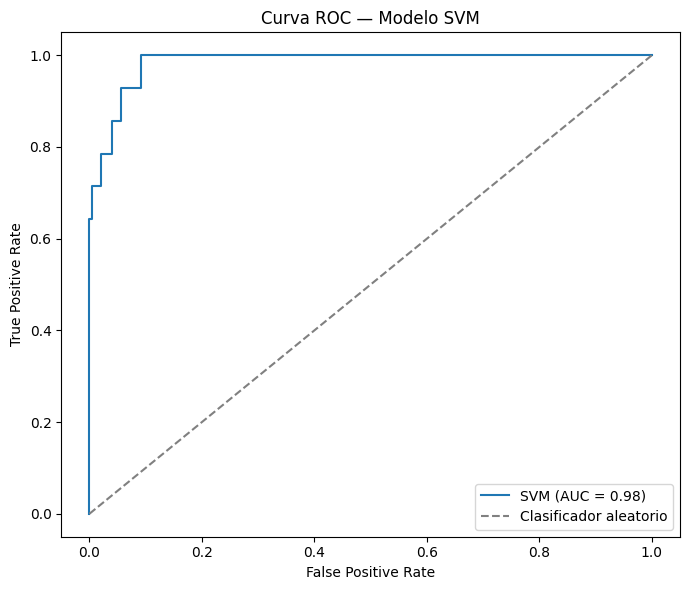

In [61]:

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Clasificador aleatorio")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC — Modelo SVM")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



**Conclusión DS – SVM**

El modelo **SVM** muestra un equilibrio sólido entre **recall de la clase minoritaria** y **control del sobreajuste**, con un **ROC AUC elevado (≈0.98)**.  
Su rendimiento confirma la existencia de **relaciones no lineales relevantes** en los datos que no todos los modelos capturan con la misma eficacia.

**Conclusión negocio – SVM**

El modelo detecta de forma fiable la mayoría de las **unidades con riesgo de deterioro**, reduciendo significativamente los **casos críticos no identificados**.  
Aunque su **interpretabilidad es menor**, resulta muy adecuado como **sistema de alerta temprana** para priorizar análisis y acciones preventivas.



### Modelo 6 PCA 

Motivación

Tras el entrenamiento de varios modelos supervisados, se observa una alta correlación entre variables financieras y operativas (ingresos, gastos, márgenes, ratios y eficiencia).
El PCA se utiliza para **reducir dimensionalidad**, eliminar redundancia y obtener una representación sintética de la **salud financiera** de las unidades de negocio

#### 6.1 Selección de variables para PCA

In [62]:
pca_features = [
    "Ingresos",
    "Gastos",
    "EBIT",
    "ROA",
    "ROE",
    "Margen_Explotacion",
    "Endeudamiento",
    "Indice_Rentabilidad",
    "Ingresos_por_Empleado",
    "Ratio_Gastos_Ingresos",
    "Solvencia",
    "Peso_Costes_Fijos",
    "Crecimiento_Ingresos"
]

X_pca = df[pca_features]


#### 6.2 Escalado

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)


#### 6.3 Ajuste del PCA

In [64]:
pca = PCA()
X_pca_components = pca.fit_transform(X_scaled)


##### 6.4 Selección del número de componentes

In [65]:
pca_final = PCA(n_components=8)
X_pca_final = pca_final.fit_transform(X_scaled)

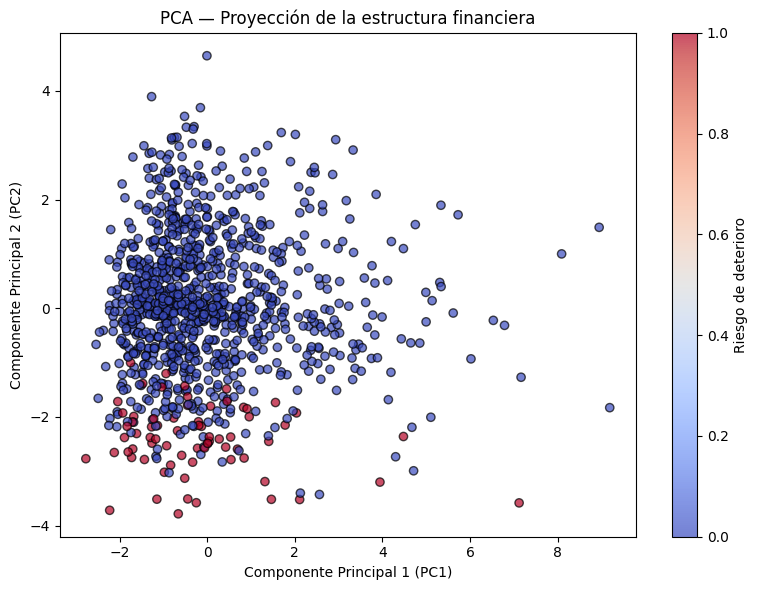

In [66]:

pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=df["Riesgo_Deterioro"],
    cmap="coolwarm",
    alpha=0.7,
    edgecolor="k"
)

plt.xlabel("Componente Principal 1 (PC1)")
plt.ylabel("Componente Principal 2 (PC2)")
plt.title("PCA — Proyección de la estructura financiera")

cbar = plt.colorbar(scatter)
cbar.set_label("Riesgo de deterioro")

plt.tight_layout()
plt.show()


##### 6.5 PCA Interpretación

Las componentes principales combinan variables de rentabilidad, eficiencia operativa y estructura financiera, confirmando que la salud financiera depende de la interacción de múltiples factores y no de un único indicador aislado.

##### 6.6 Conclusiones PCA

**Conclusión DS**

El PCA confirma una fuerte correlación estructural entre las variables financieras. La reducción a 8 componentes elimina redundancia y multicolinealidad, proporcionando una representación compacta y estable del espacio financiero.

**Conclusión negocio**

El PCA sintetiza numerosos indicadores financieros en unos pocos ejes claros que representan el comportamiento global de las unidades, facilitando comparaciones y análisis estratégicos sin depender de múltiples métricas individuales.



### 7 KMeans

##### 7.1 Objetivo del clustering

El objetivo del clustering es identificar grupos homogéneos de **unidades de negocio** en función de su comportamiento financiero, sin utilizar la variable objetivo.

El algoritmo se aplica sobre las componentes principales obtenidas con PCA para reducir ruido y evitar sesgos por variables correlacionadas.


##### 7.2 KMeans

In [67]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca_final)

df["Cluster"] = clusters



##### 7.3 Perfilado de clusters

In [68]:
cluster_profile = df.groupby("Cluster")[pca_features].mean()
cluster_profile


,Ingresos,Gastos,EBIT,ROA,ROE,Margen_Explotacion,Endeudamiento,Indice_Rentabilidad,Ingresos_por_Empleado,Ratio_Gastos_Ingresos,Solvencia,Peso_Costes_Fijos,Crecimiento_Ingresos
Cluster,,,,,,,,,,,,,
0,48850.789715,37238.476378,11332.049238,0.065834,0.098853,0.238776,0.566609,0.017246,379.761446,0.760608,1.918223,0.414636,0.098372
1,20374.583026,16019.849192,4308.637729,0.064705,0.112626,0.267855,0.534807,0.037128,113.189849,0.782847,1.774265,0.413716,0.092888
2,21336.576742,16611.478134,4771.099546,0.061795,0.090794,0.151427,0.690770,-0.049045,120.906211,0.776381,1.921019,0.402085,0.097070


##### 7.4 Conclusiones KMeans

**Conclusión DS – KMeans**

El clustering identifica perfiles financieros diferenciados entre las unidades de negocio. El uso previo de PCA mejora la estabilidad del algoritmo y permite una segmentación basada en patrones latentes reales.

**Conclusión negocio – KMeans**

El clustering permite segmentar las unidades en perfiles financieros comparables, facilitando benchmarking interno, priorización de acciones y diseño de estrategias diferenciadas por tipo de unidad.


# 2 Evaluación de modelos 

Evaluación comparativa de modelos supervisados

Se evalúan cinco modelos supervisados utilizando un conjunto de test común y métricas adecuadas a un problema con desbalance de clases, priorizando:

Recall de la clase minoritaria (riesgo),F1-score,ROC AUC como métrica global de discriminación.

Los resultados se resumen en una tabla comparativa para facilitar la selección del modelo final.

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Algunos modelos van en Pipeline, otros no: todos tienen predict_proba
    y_proba = model.predict_proba(X_test)[:, 1]
    
    return {
        "Modelo": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_proba)
    }

models_results = []

models_results.append(
    evaluate_model("LogReg_baseline", baseline_model, X_test, y_test)
)

models_results.append(
    evaluate_model("LogReg_balanced", pipe, X_test, y_test)
)

models_results.append(
    evaluate_model("Decision_Tree", tree, X_test, y_test)
)

models_results.append(
    evaluate_model("Random_Forest", rf_reg, X_test, y_test)
)

models_results.append(
    evaluate_model("SVM", svm_pipe, X_test, y_test)
)

results_df = pd.DataFrame(models_results)

results_df.sort_values(by="ROC_AUC", ascending=False)




c:\Users\balle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Modelo,Accuracy,Precision,Recall,F1,ROC_AUC
1,LogReg_balanced,0.956938,0.608696,1.000000,0.756757,0.996703
3,Random_Forest,0.995215,1.000000,0.928571,0.962963,0.994139
4,SVM,0.956938,0.647059,0.785714,0.709677,0.984615
2,Decision_Tree,0.995215,1.000000,0.928571,0.962963,0.964286
0,LogReg_baseline,0.933014,0.000000,0.000000,0.000000,0.601099


### Conclusión comparativa de modelos predictivos 

#### **DS**

- **Random Forest y Árbol de Decisión** alcanzan métricas casi perfectas, lo que sugiere sobreajuste dado el tamaño y carácter sintético del dataset.

- **Logistic Regression balanceada** mejora notablemente frente al baseline, pero presenta limitaciones para capturar relaciones no lineales.

- **SVM** ofrece el **mejor equilibrio** sesgo–varianza, con:

    * **Alto recall** en la clase minoritaria,

    * **ROC AUC** elevado,

    * Buen control del sobreajuste.

Por estos motivos, **SVM se selecciona como modelo final supervisado**.

#### **Negocio**

El análisis comparativo confirma que no todos los modelos con alta precisión son adecuados para detectar riesgo, ya que la mayoría incurren en overfitting.
El modelo **SVM permite identificar de forma fiable la mayoría de unidades en riesgo**, minimizando los casos críticos no detectados.

Esto lo convierte en la **opción más segura como sistema de alerta temprana**, equilibrando precisión y capacidad de detección real.

### Evaluación del modelo no supervisado (PCA + KMeans)

El enfoque PCA + KMeans no se evalúa mediante métricas de clasificación, 
ya que no utiliza la variable objetivo. Su valor reside en el análisis 
estructural del dataset.


# Selección del modelo final

La selección del modelo final se ha realizado exclusivamente entre los modelos supervisados, ya que son los únicos orientados a la predicción del riesgo de deterioro.


In [70]:
best_model = svm_pipe

**DS**

Tras la evaluación comparativa, el modelo SVM se selecciona como modelo final por ofrecer **el mejor equilibrio entre capacidad predictiva, control del sobreajuste y detección de la clase minoritaria**. Aunque otros modelos presentan métricas superiores, estas se consideran indicativas de sobreajuste dadas las características del dataset.

**Negocio**

El modelo seleccionado **maximiza la detección temprana de unidades en riesgo, reduciendo falsos negativos críticos**. Aunque no es el modelo más simple, ofrece **mayor fiabilidad operativa como sistema de alerta temprana**.